In [1]:
import os
import pandas as pd
import configparser
#import mysql.connector
from sqlalchemy import create_engine

import seaborn as sns
import matplotlib.pyplot as plt

config = configparser.ConfigParser()
config.read('..\\config.ini')

host = config['mysql']['host']
database = config['mysql']['database']
user = config['mysql']['user']
password = config['mysql']['password']
port = config['mysql']['port']

In [2]:
def read_query(query):
    engine = create_engine(f'mysql+pymysql://{user}:{password}@{host}:{port}/{database}')
    df = pd.read_sql(query, con=engine)
    print('Query Executed!')
    return df

In this notebook we will start by exploring the `transactions` table to get a better idea of the items. Once we have a better idea, we can decide on the type of recommender system we should build.

Checking the basic structure of the data:

In [5]:
query = """
SELECT *
FROM transactions
LIMIT 20;
"""

read_query(query)

Query Executed!


,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2
5,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687001,0.016932,2
6,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221001,0.020322,2
7,2018-09-20,00083cda041544b2fbb0e0d2905ad17da7cf1007526fb4...,688873012,0.030492,1
8,2018-09-20,00083cda041544b2fbb0e0d2905ad17da7cf1007526fb4...,501323011,0.053373,1
9,2018-09-20,00083cda041544b2fbb0e0d2905ad17da7cf1007526fb4...,598859003,0.045746,2


Checking the starting date and end date:

In [4]:
query = """
SELECT 
    MAX(t_dat) AS end_date, MIN(t_dat) AS start_date
FROM
    transactions;
"""

read_query(query)

Query Executed!


,end_date,start_date
0,2020-09-22,2018-09-20


The dataset contains transaction history of customers from 2018-09-18 to 2020-09-22 which is roughly 2 years.

When training our model, this feature will be of no use but instead of using the specific dates, we can extract the month and even check if the day is a weekend or not since this will help us get a better idea of the spending habits of the customers. 

However, before we do these feature engineering, we will need to remove `customer_id` not present in the `customer_preprocessed` table we created earlier. Moreover, the data contains transaction activity of both online and in-person shopping but since we are trying to create a recommender for only online users, we can remove instances where sales_channel_id = 1 (indicating store purchases). 

Checking if price of product remained same over these 2 years:

In [3]:
q = """
SELECT 
    T.article_id, COUNT(*) AS price_changes
FROM
    (SELECT 
        article_id
    FROM
        transactions
    WHERE
        sales_channel_id = 2
    GROUP BY article_id , price) T
GROUP BY T.article_id;
"""

all_changes = read_query(q)
all_changes

Query Executed!


,article_id,price_changes
0,108775015,130
1,108775044,125
2,108775051,11
3,110065001,43
4,110065002,28
...,...,...
98317,952267001,8
98318,952938001,3
98319,953450001,2
98320,953763001,7


We can see clearly that the same article_id has different prices indicating that the price for that item had changed over the years.

Since price is always an important factor when trying to decide what to buy we clearly need to fix this issue. The site where this model will be deployed will have the price of the items always fixed, so we need to do the same for our training set. 

In [6]:
location_of_subfolders = "..//h-and-m-personalized-fashion-recommendations//images"

# Get a list of all files in the folder
subfolder_names = os.listdir(location_of_subfolders)

all_articles = []

# Print the names of all files in the folder
for name in subfolder_names:
    location_of_images = os.path.join(location_of_subfolders,name)
    image_names = os.listdir(location_of_images)
    all_articles = all_articles + [int(x.replace('.jpg', '')) for x in image_names]

In [7]:
all_items = """
SELECT 
    *
FROM
    transactions
WHERE
    sales_channel_id = 2
"""

items_all = read_query(all_items)

Query Executed!


In [8]:
new_articles_df = items_all[items_all['article_id'].isin(all_articles)]

Saving the table in the database to be used later:

In [ ]:
new_articles_df['customer_id'] = new_articles_df['customer_id'].astype('category')
new_articles_df['article_id'] = new_articles_df['article_id'].astype('category')

In [ ]:
new_articles_df['t_dat'] = new_articles_df['t_dat'].astype('datetime64[ns]')

In [ ]:
new_articles_df['price'] = new_articles_df['price'].astype('float32')

In [26]:
new_articles_df = new_articles_df.drop('sales_channel_id', axis=1)

In [28]:
new_articles_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22283034 entries, 0 to 22379861
Data columns (total 4 columns):
 #   Column       Dtype         
---  ------       -----         
 0   t_dat        datetime64[ns]
 1   customer_id  category      
 2   article_id   category      
 3   price        float32       
dtypes: category(2), datetime64[ns](1), float32(1)
memory usage: 638.5 MB


In [29]:
engine = create_engine(f'mysql+pymysql://{user}:{password}@{host}:{port}/{database}')

new_articles_df.to_sql('transactions_processed', engine, if_exists='replace', index=False)

22283034

Get total transactions of each product in 2018:

In [3]:
q="""
SELECT 
    t_dat,
    article_id,
    COUNT(*) AS total_purchase
FROM
    transactions_processed
WHERE
    t_dat BETWEEN '2018-09-18' AND '2018-12-31' 
GROUP BY t_dat, article_id;
"""

df_2018 = read_query(q) 

Query Executed!


In [35]:
df_2018

,t_dat,article_id,total_purchase
0,2018-09-20,663713001,4
1,2018-09-20,541518023,8
2,2018-09-20,505221004,9
3,2018-09-20,685687003,242
4,2018-09-20,685687004,443
...,...,...,...
864742,2018-12-31,668767004,1
864743,2018-12-31,665330002,1
864744,2018-12-31,702883001,1
864745,2018-12-31,700746002,1


Get total transactions of each product in 2019:

In [4]:
q="""
SELECT 
    t_dat,
    article_id,
    COUNT(*) AS total_purchase
FROM
    transactions_processed
WHERE
    t_dat BETWEEN '2019-01-01' AND '2019-12-31' 
GROUP BY t_dat, article_id;
"""

df_2019 = read_query(q)

Query Executed!


In [5]:
df_2019

,t_dat,article_id,total_purchase
0,2019-01-01,304766008,3
1,2019-01-01,662916002,1
2,2019-01-01,740909001,3
3,2019-01-01,666382002,14
4,2019-01-01,583534018,1
...,...,...,...
2845421,2019-12-31,560338001,1
2845422,2019-12-31,806973001,1
2845423,2019-12-31,787880005,1
2845424,2019-12-31,792695001,2


Get total transactions of each product in 2020:

In [9]:
q="""
SELECT 
    t_dat,
    article_id,
    COUNT(*) AS total_purchase
FROM
    transactions_processed
WHERE
    t_dat BETWEEN '2020-01-01' AND '2020-09-23' 
GROUP BY t_dat, article_id;
"""

df_2020 = read_query(q)

Query Executed!


In [10]:
df_2020

,t_dat,article_id,total_purchase
0,2020-01-01,835247001,17
1,2020-01-01,802930002,1
2,2020-01-01,760084008,18
3,2020-01-01,804662002,1
4,2020-01-01,801554002,1
...,...,...,...
1854398,2020-09-22,864339003,1
1854399,2020-09-22,881448002,1
1854400,2020-09-22,701472004,1
1854401,2020-09-22,832505003,1


Saving the three new tables to avoid having to run these memory intensive queries everytime:

In [11]:
engine = create_engine(f'mysql+pymysql://{user}:{password}@{host}:{port}/{database}')

df_2018.to_sql('transactions_2018', engine, if_exists='replace', index=False)
df_2019.to_sql('transactions_2019', engine, if_exists='replace', index=False)
df_2020.to_sql('transactions_2020', engine, if_exists='replace', index=False)

1854403

Instead of using individual dates, we can group them into weekdays and weekends:

In [15]:
q = """
WITH all_purchase AS (
SELECT 
    article_id,
    SUM(total_purchase) AS Total,
    CASE
        WHEN WEEKDAY(t_dat) IN (0 , 6) THEN 'weekend'
        ELSE 'weekday'
    END AS day_type
FROM
    transactions_2018
GROUP BY day_type , article_id 
UNION SELECT 
    article_id,
    SUM(total_purchase) AS Total,
    CASE
        WHEN WEEKDAY(t_dat) IN (0 , 6) THEN 'weekend'
        ELSE 'weekday'
    END AS day_type
FROM
    transactions_2019
GROUP BY day_type , article_id 
UNION SELECT 
    article_id,
    SUM(total_purchase) AS Total,
    CASE
        WHEN WEEKDAY(t_dat) IN (0 , 6) THEN 'weekend'
        ELSE 'weekday'
    END AS day_type
FROM
    transactions_2020
GROUP BY day_type , article_id
)
SELECT article_id, sum(Total) as total_purchases, day_type
FROM all_purchase
GROUP BY article_id, day_type;
"""

days_df = read_query(q)

Query Executed!


In [16]:
days_df

,article_id,total_purchases,day_type
0,663713001,274.0,weekday
1,541518023,90.0,weekday
2,505221004,36.0,weekday
3,685687003,1024.0,weekday
4,685687004,1427.0,weekday
...,...,...,...
185097,923522001,1.0,weekday
185098,533261032,1.0,weekday
185099,876372002,1.0,weekday
185100,876372001,1.0,weekday


Now that we have all our transactions of each product grouped by `day_type` we can visualize our data to see the breakdown by weekdays and weekends:

In [27]:
grouped_days = days_df.groupby('day_type')['total_purchases'].sum().reset_index()

Since we have 5 weekdays and 2 weekends, we cannot use the total sum but need to standardize our results first:

In [29]:
grouped_days.loc[grouped_days['day_type']=='weekend', 'total_purchases']/=2
grouped_days.loc[grouped_days['day_type']=='weekday', 'total_purchases']/=5

In [30]:
grouped_days

,day_type,total_purchases
0,weekday,3203886.6
1,weekend,3121354.5


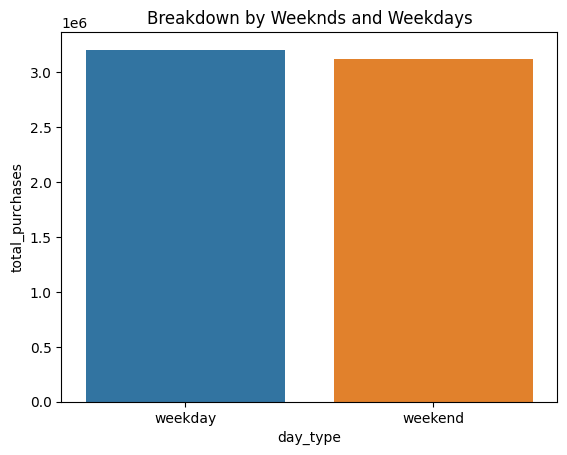

In [32]:
sns.barplot(x='day_type', y='total_purchases', data= grouped_days)

plt.title('Breakdown by Weeknds and Weekdays')
plt.show()

The total items bought seem to be similar on weekdays and weekend.

A naive a recoomender system would recommend items based on how popular it was in the past. So for our initial system, we will use the total transactions data grouped into weekdays and weekends to build a simple popularity based recommender system. Before we can continue, we need to save our table of total_purchases grouped by day_type.

In [34]:
days_df.to_sql('popularity_v1', engine, if_exists='replace', index=False)

185102